### Примечание
в некоторых ячейках очень длинные принты, возможно, для проверки будет удобнее склонировать, чем смотреть на сайте. Выводы (пункты 6-8) - в самом конце.

In [1]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

C:\Users\001C~1\AppData\Local\conda\conda\envs\mllecture\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\001C~1\AppData\Local\conda\conda\envs\mllecture\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
from tqdm import tqdm
from rnnmorph.predictor import RNNMorphPredictor

Using TensorFlow backend.
C:\Users\001C~1\AppData\Local\conda\conda\envs\mllecture\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\001C~1\AppData\Local\conda\conda\envs\mllecture\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейки нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [3]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalnum()]
    return clean

## Возьмем те же данные

In [5]:
habr_texts = []
for text in tqdm(open('../data/habr_texts.txt',encoding='utf-8')):
    habr_texts.append(clean(word_tokenize(remove_tags(text.lower()))))

3990it [34:36,  1.92it/s]


In [7]:
print(habr_texts[0])

['masstransit', 'это', 'open', 'source', 'библиотека', 'разработать', 'на', 'язык', 'c', 'для', 'платформа', 'упрощать', 'работа', 'с', 'шина', 'дать', 'который', 'использоваться', 'при', 'построение', 'распределенный', 'приложение', 'и', 'реализация', 'soa', 'service', 'oriented', 'architecture', 'в', 'качество', 'message', 'broker', 'мочь', 'выступать', 'rabbitmq', 'azure', 'service', 'bus', 'или', 'менеджер', 'в', 'случай', 'с', 'область', 'видимость', 'ограничиваться', 'процесс', 'в', 'который', 'проинициализировать', 'экземпляр', 'команда', 'и', 'событиякоманда', 'событие', 'контракт', 'сообщение', 'роутингexchange', 'формат', 'сообщение', 'консьюмер', 'consumer', 'конфигурация', 'контейнер', 'di', 'наблюдатель', 'observer', 'новое', 'в', 'masstransit', 'заключение', 'опрос', 'а', 'какой', 'библиотека', 'использовать', 'вы', 'команда', 'и', 'событие', 'в', 'библиотека', 'заложить', '2', 'основный', 'тип', 'сообщение', 'команда', 'и', 'сигнализировать', 'о', 'необходимость', 'выпол

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [12]:
def write_to_vw(habr_texts):
    f = open('habr_texts.vw', 'w', encoding='utf-8')

    for i, text in enumerate(habr_texts):
        c = Counter(text)
        doc = 'doc_'+ str(i) + ' '
        vw_text = ' '.join([x.replace(':','_')+':'+str(c[x]) for x in c])
        f.write(doc + vw_text  + '\n')
    f.close()

write_to_vw(habr_texts)

Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [27]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [10]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [11]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [12]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [13]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [14]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [15]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [16]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [17]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [18]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 1142.641 (ARTM)


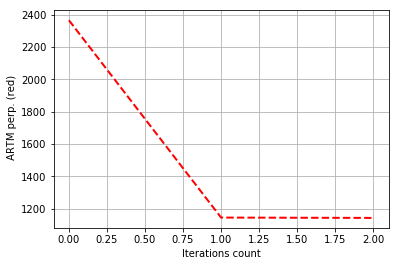

In [19]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [20]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]))

In [21]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [22]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.787 ARTM)
Sparsity Theta: 0.091 (ARTM)
Kernel contrast: 0.264 (ARTM)
Kernel purity: 0.239 (ARTM)
Perplexity: 750.273 (ARTM)


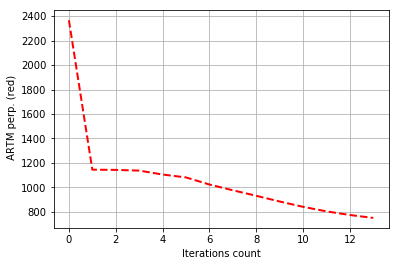

In [23]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [24]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
дверь
капитан
пират
страх
новогодний
рука
пиратский
герой
юлмарт
годность
---------
topic_1: 
устройство
intel
ноутбук
атака
компьютер
процессор
злоумышленник
память
lenovo
usb
---------
topic_2: 
человек
ты
лекция
курс
книга
социальный
мой
сказать
день
вопрос
---------
topic_3: 
информационный
решение
компания
разработка
проект
являться
процесс
результат
обеспечение
развитие
---------
topic_4: 
робот
говорить
результат
современный
процесс
дело
задача
качество
количество
сейчас
---------
topic_5: 
устройство
регистратор
аккумулятор
китайский
камера
дрон
технология
батарея
gps
производитель
---------
topic_6: 
ваш
вопрос
человек
продукт
пользователь
сайт
кто
да
хотеть
ни
---------
topic_7: 
заказчик
задача
команда
scrum
проект
ресурс
спринт
тз
сервер
сервис
---------
topic_8: 
gt
lt
1
2
include
html
key
file
print
li
---------
topic_9: 
программа
объект
язык
функция
часть
ошибка
тип
элемент
следующий
некоторый
---------
topic_10: 
регистрация
статья
надо
вот
следующий
необходи

Даже с настройками по умолчанию получаются некоторые вменяемые темы (topic_22 - что-то про качество звука, topic_24 - что-то про космос), но в целом слишком много общих слов.

# добавим энграммы, удалим стоп-слова

In [26]:
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian'))) 
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

In [27]:
ngrammed_habr_texts[1]

['введение',
 'и',
 'выбор',
 'решение',
 'рано_или_поздно',
 'наступать',
 'такой',
 'момент',
 'в',
 'жизнь',
 'любой',
 'сообщество',
 'форум',
 'когда',
 'для',
 'привлечение_и_удержание',
 'человек',
 'возникать',
 'острый_необходимость',
 'использование',
 'новое',
 'инструментарий',
 'и',
 'такой',
 'весьма',
 'эффективный',
 'инструмент',
 'являться',
 'то',
 'что',
 'крыться_за_модный',
 'ныне',
 'слово_геймификация',
 'то',
 'есть',
 'использование',
 'характерный',
 'для',
 'игра',
 'приём',
 'и',
 'подход_в_неигровой',
 'процесс',
 'по',
 'привлечение_и_вовлечение',
 'участник_сообщество',
 'на',
 'форум',
 'в',
 'создание',
 'активный',
 'и',
 'мощный',
 'информационный',
 'поль',
 'вокруг',
 'наш',
 'продукт',
 'использовать',
 'в',
 'наш',
 'компания_форумный',
 'движок_xenforo',
 'в',
 'настоящее_время',
 'являться',
 'наиболее_популярный',
 'и',
 'быстро_развивающийся',
 'этот',
 'движок',
 'иметь',
 'встроить',
 'система',
 'трофей_основать',
 'на',
 'собственный',
 '

стоп-слов остается все равно слишком много. Попробуем разметить рннМорф и взять только знаменательные части речи (почему рннМорф - раньше никогда не пользовалась, интересно, как работает)

In [4]:
predictor = RNNMorphPredictor(language="ru")
def clean(words):
    forms = predictor.predict(words)
    clean = [form.normal_form for form in forms if form.pos in {'NOUN','PROPN','ADJ','VERB'}]
    return clean
habr_texts = []
for text in tqdm(open('habr_texts.txt',encoding='utf-8')):
    habr_texts.append(clean(word_tokenize(remove_tags(text.lower()))))
print(habr.texts[1]) #без опечатки см. ниже 

C:\Users\001C~1\AppData\Local\conda\conda\envs\mllecture\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
3990it [2:59:37,  2.70s/it]


NameError: name 'habr' is not defined

In [6]:
print(habr_texts[1][:15])

['введение', 'выбор', 'решение', 'наступать', 'момент', 'жизнь', 'сообщество', 'форум', 'привлечение', 'удержание', 'человек', 'возникать', 'острый', 'необходимость', 'использование']


In [7]:
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, 
                           common_terms=set(stopwords.words('russian'))) 
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

In [18]:
ngrammed_habr_texts[1][:15]

['введение',
 'выбор',
 'решение',
 'наступать_момент',
 'жизнь',
 'сообщество',
 'форум',
 'привлечение_удержание',
 'человек',
 'возникать',
 'острый_необходимость',
 'использование',
 'новый',
 'инструментарий',
 'эффективный']

In [13]:
write_to_vw(ngrammed_habr_texts)

In [14]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000)
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)
dictionary.save_text('dict_ngrams.txt')

In [31]:
params={'topics_num':0,'phi_tau':0,'theta_tau':0, 'iteration':0}
def evaluate(topics_num, params):
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(topics_num)])
    model_artm.initialize(dictionary=dictionary, )
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы
    model_artm.num_document_passes = 2
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)
    
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                                topic_names=['topic_{}'.format(i) for i in range(1, topics_num)],
                                                                ))
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                                  topic_names=['topic_{}'.format(i) for i in range(1, topics_num)]))
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

    perplex = model_artm.score_tracker['PerplexityScore'].last_value
    params['topics_num']=topics_num
    phi_tau = model_artm.regularizers['SparsePhi'].tau
    theta_tau = model_artm.regularizers['SparseTheta'].tau
    params['phi_tau']=phi_tau
    params['theta_tau']=theta_tau
    
    for i in range(10):
        model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
        model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))      
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)


        if model_artm.score_tracker['PerplexityScore'].last_value < perplex:
            perplex = model_artm.score_tracker['PerplexityScore'].last_value
            params['topics_num']=topics_num
            params['phi_tau']=model_artm.regularizers['SparsePhi'].tau
            params['theta_tau']=model_artm.regularizers['SparseTheta'].tau
            params['iteration']=i+2
    print_measures(model_artm)
    print(params)
    for topic_name in model_artm.topic_names[:50]:
        print(topic_name + ': ')
        try:
            for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
                print(x)
            print('---------')

        except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
            continue

### Разные количества топиков:

Sparsity Phi: 0.902 ARTM)
Sparsity Theta: 0.189 (ARTM)
Kernel contrast: 0.419 (ARTM)
Kernel purity: 0.317 (ARTM)
Perplexity: 827.122 (ARTM)


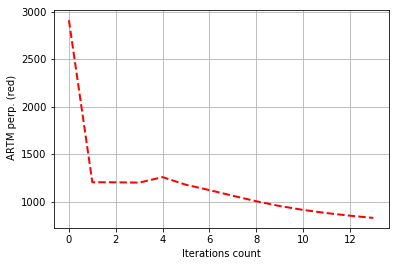

{'phi_tau': -0.22499999999999998, 'topics_num': 200, 'iteration': 11, 'theta_tau': -0.16499999999999998}
topic_0: 
код
функция
вывод
загрузка
раз
данный
приз
дело
the
выйти
---------
topic_1: 
уязвимость
устройство
защита
компьютер
эксплуатация
электронный_почта
проблема
информационный_безопасность
атака
уязвимый
---------
topic_2: 
человек
час
хороший
сказать
станок
день
дело
делать
слово
стол
---------
topic_3: 
регион
являться
система
оценка
результат
импульс
большой
процесс
решение
проблема
---------
topic_4: 
результат
иметь
раз
программа
разница
такт
процессор
общий
кристалл
процесс
---------
topic_5: 
камера
аккумулятор
батарея
видео
аппарат
устройство
разрешение
стекло
качество
съёмка
---------
topic_6: 
пост
контроллер
пользователь
простой
получить
функция
статья
добавить
необходимый
использование
---------
topic_7: 
заказчик
ошибка
лог
задача
команда
статус
данные
процесс
тестовый
ответ
---------
topic_8: 
участник
доклад
конференция
тема
рассказать
мероприятие
презентация
вы

In [32]:
evaluate(200, params)

Sparsity Phi: 0.874 ARTM)
Sparsity Theta: 0.124 (ARTM)
Kernel contrast: 0.382 (ARTM)
Kernel purity: 0.311 (ARTM)
Perplexity: 864.881 (ARTM)


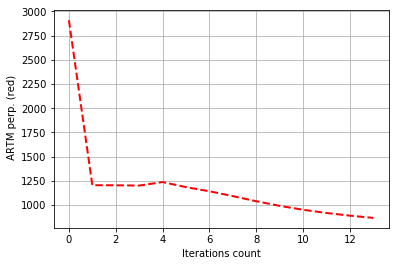

{'phi_tau': -0.22499999999999998, 'topics_num': 150, 'iteration': 11, 'theta_tau': -0.16499999999999998}
topic_0: 
код
функция
трансляция
опубликовать
загрузка
вывод
данный
the
раз
опубликованный
---------
topic_1: 
устройство
атака
уязвимость
защита
злоумышленник
шифрование
сеть
безопасность
угроза
электронный_почта
---------
topic_2: 
человек
сказать
хороший
час
курс
лекция
день
станок
делать
слово
---------
topic_3: 
регион
система
являться
оценка
результат
большой
процесс
проблема
решение
количество
---------
topic_4: 
иметь
результат
раз
задача
общий
процесс
программа
качество
простой
получить
---------
topic_5: 
камера
видео
аккумулятор
батарея
аппарат
качество
стекло
устройство
принтер
разрешение
---------
topic_6: 
пост
пользователь
иконка
простой
получить
контроллер
статья
необходимый
добавить
использование
---------
topic_7: 
данные
кэш
соединение
лог
запрос
ошибка
ответ
сервер
задача
пул
---------
topic_8: 
участник
доклад
конференция
тема
рассказать
мероприятие
презентация


In [33]:
evaluate(150, params)

Sparsity Phi: 0.920 ARTM)
Sparsity Theta: 0.256 (ARTM)
Kernel contrast: 0.454 (ARTM)
Kernel purity: 0.327 (ARTM)
Perplexity: 795.735 (ARTM)


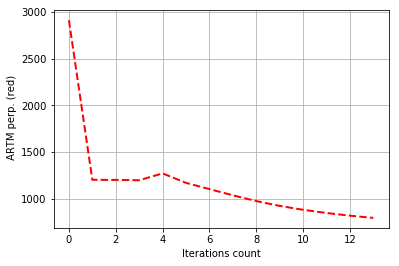

{'phi_tau': -0.22499999999999998, 'topics_num': 250, 'iteration': 11, 'theta_tau': -0.16499999999999998}
topic_0: 
раз
присоединиться
дело
проблема
являться
вывод
иметь
загрузка
код
функция
---------
topic_1: 
уязвимость
защита
эксплуатация
атака
компьютер
информационный_безопасность
жертва
устройство
проблема
обнаружить
---------
topic_2: 
курс
человек
лекция
час
сказать
хороший
слово
дело
день
занятие
---------
topic_3: 
являться
оценка
система
импульс
результат
большой
процесс
разработанный
предполагаться
решение
---------
topic_4: 
иметь
разница
результат
раз
кристалл
герой
август
поздний
ревить
программа
---------
topic_5: 
камера
разрешение
аппарат
видео
точка_доступ
wi-fi
стекло
качество
китайский
устройство
---------
topic_6: 
контроллер
пост
пользователь
добавить
простой
получить
функция
статья
необходимый
название
---------
topic_7: 
заказчик
лог
ошибка
статус
ответ
задача
исполнитель
тестовый
база
сервер
---------
topic_8: 
участник
доклад
конференция
тема
рассказать
презент

In [34]:
evaluate(250, params)

### Эксперименты с 250 темами

In [58]:
def evaluate(flag, num_collection_passes, num_document_passes):
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(250)])
    model_artm.initialize(dictionary=dictionary, )
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы
    model_artm.num_document_passes = num_document_passes
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
    if flag == 'phi' or flag == 'both':
        model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                                    topic_names=['topic_{}'.format(i) for i in range(1, 250)],
                                                                    ))
        phi_tau = model_artm.regularizers['SparsePhi'].tau
    
    if flag =='theta' or flag == 'both':
        model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                                      topic_names=['topic_{}'.format(i) for i in range(1, 250)]))
        theta_tau = model_artm.regularizers['SparseTheta'].tau
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

    
    for i in range(10):
        if flag == 'phi'or flag == 'both':
            model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
        elif flag == 'theta'or flag == 'both':
            model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))      
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
            
    print_measures(model_artm)
#     if flag == 'phi' or flag == 'both':
#         print(model_artm.regularizers['SparsePhi'].tau)
#     if flag == 'theta' or flag == 'both':
#         print(model_artm.regularizers['SparseTheta'].tau)
#     for topic_name in model_artm.topic_names[:50]:
#         print(topic_name + ': ')
#         try:
#             for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
#                 print(x)
#             print('---------')

#         except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
#             continue
    return model_artm.score_tracker['TopTokensScore_1'].last_tokens

Sparsity Phi: 0.913 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.431 (ARTM)
Kernel purity: 0.288 (ARTM)
Perplexity: 839.853 (ARTM)


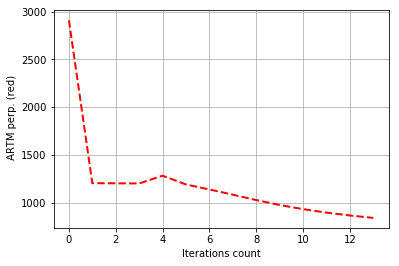

-0.22499999999999998
topic_0: 
загрузка
код
вывод
являться
дело
иметь
самый_дело
раз
выйти
полный_картина
---------
topic_1: 
уязвимость
устройство
защита
эксплуатация
жертва
компьютер
атака
информационный_безопасность
злоумышленник
канал_связь
---------
topic_2: 
человек
курс
час
лекция
сказать
хороший
слово
день
дело
мысль
---------
topic_3: 
регион
система
импульс
являться
результат
оценка
большой
количество
проблема
процесс
---------
topic_4: 
иметь
результат
разница
кристалл
раз
задача
ревить
качество
процесс
программа
---------
topic_5: 
камера
видео
регистратор
разрешение
аппарат
модель
китайский
качество
устройство
стекло
---------
topic_6: 
контроллер
пост
пользователь
простой
необходимый
получить
статья
использование
функция
добавить
---------
topic_7: 
заказчик
ошибка
задача
лог
исполнитель
статус
данные
проект
процесс
команда
---------
topic_8: 
участник
доклад
конференция
мероприятие
рассказать
тема
презентация
выступление
выступать
пройти
---------
topic_9: 
программа
час

In [39]:
evaluate('phi', 3, 2)

Sparsity Phi: 0.007 ARTM)
Sparsity Theta: 0.175 (ARTM)
Kernel contrast: 0.224 (ARTM)
Kernel purity: 0.159 (ARTM)
Perplexity: 845.668 (ARTM)


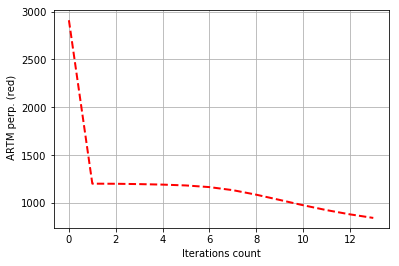

-0.16499999999999998
topic_0: 
доклад
конференция
тема
рассказать
презентация
встреча
слайд
ноябрь
интересный
декабрь
---------
topic_1: 
уязвимость
устройство
проблема
компьютер
защита
эксплуатация
версия
уровень
данный
атакующий
---------
topic_2: 
человек
час
курс
лекция
хороший
сказать
слово
день
говорить
делать
---------
topic_3: 
система
являться
регион
результат
процесс
оценка
решение
большой
проблема
количество
---------
topic_4: 
результат
иметь
процесс
задача
программа
раз
общий
простой
инструкция
помощь
---------
topic_5: 
печать
принтер
материал
изделие
стекло
3d-принтер
позволять
плата
качество
металл
---------
topic_6: 
пользователь
контроллер
необходимый
простой
получить
использование
статья
пост
добавить
функция
---------
topic_7: 
данные
кэш
пул
ответ
ошибка
лог
запрос
задача
сервер
кэширование
---------
topic_8: 
участник
соревнование
вопрос
выступление
человек
хакатон
получить
конференция
тема
билет
---------
topic_9: 
программа
часть
иметь
процесс
разный
слово
найти

In [40]:
evaluate('theta', 3, 2)

Sparsity Phi: 0.927 ARTM)
Sparsity Theta: 0.269 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.377 (ARTM)
Perplexity: 755.252 (ARTM)


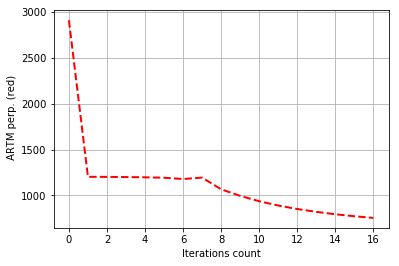

-0.22499999999999998
-0.15
topic_0: 
код
функция
вывод
данный
загрузка
создать
раз
выполняться
являться
общий
---------
topic_1: 
уязвимость
защита
проблема
эксплуатация
обнаружить
компьютер
обнаружение
информационный_безопасность
устройство
уязвимый
---------
topic_2: 
курс
час
человек
лекция
сказать
хороший
слово
дело
занятие
знать
---------
topic_3: 
регион
являться
результат
значительный
система
оценка
причина
количество
настоящий_время
связанный
---------
topic_4: 
инструкция
результат
программа
процессор
иметь
intel
компьютер
раз
поздний
общий
---------
topic_5: 
печать
принтер
стекло
материал
позволять
качество
разрешение
изделие
3d-принтер
метр
---------
topic_6: 
контроллер
пост
пользователь
роль
получить
простой
функция
статья
добавить
название
---------
topic_7: 
лог
кэш
статус
ошибка
пул
секунда
нагрузка
ответ
тестовый
база
---------
topic_8: 
участник
доклад
конференция
рассказать
презентация
тема
мероприятие
выступление
интересный
пройти
---------
topic_9: 
программа
част

In [49]:
evaluate('both', 6, 2)

Sparsity Phi: 0.935 ARTM)
Sparsity Theta: 0.302 (ARTM)
Kernel contrast: 0.436 (ARTM)
Kernel purity: 0.424 (ARTM)
Perplexity: 721.048 (ARTM)


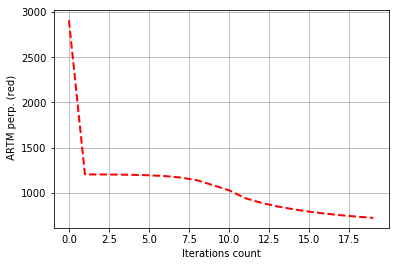

-0.22499999999999998
-0.15
topic_0: 
хранилище
механизм
субд
данные
удаление
код
функция
необходимый
выполняться
данный
---------
topic_1: 
уязвимость
проблема
обнаружить
обнаружение
эксплуатация
закрытый
данный
новость
устройство
уязвимый
---------
topic_2: 
курс
час
человек
лекция
занятие
хороший
сказать
неделя
изучать
слово
---------
topic_3: 
регион
являться
значительный
оценка
результат
причина
система
считаться
настоящий_время
связанный
---------
topic_4: 
intel
результат
иметь
процесс
раз
общий
кристалл
подробность
быстрый
простой
---------
topic_5: 
принтер
материал
конструкция
изделие
позволять
стекло
сборка
размер
3d-принтер
печать
---------
topic_6: 
контроллер
пост
получить
статья
простой
роль
комментарий
обратить_внимание
давать
стандартный
---------
topic_7: 
лог
кэш
секунда
статус
база
нагрузка
тестовый
ответ
пул
ошибка
---------
topic_8: 
участник
доклад
конференция
презентация
тема
рассказать
мероприятие
интересный
выступление
пройти
---------
topic_9: 
программа
часть

In [50]:
evaluate('both', 9, 2)

Sparsity Phi: 0.941 ARTM)
Sparsity Theta: 0.337 (ARTM)
Kernel contrast: 0.403 (ARTM)
Kernel purity: 0.473 (ARTM)
Perplexity: 692.552 (ARTM)


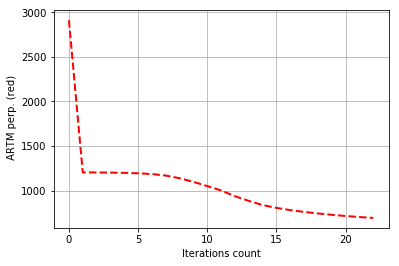

-0.22499999999999998
-0.15
topic_0: 
база_данные
данные
хранение
хранилище
хранить
механизм
удаление
сущность
хранение_данные
храниться
---------
topic_1: 
уязвимость
проблема
обнаружить
новость
закрытый
обнаружение
данный
уязвимый
жертва
обнаруженный
---------
topic_2: 
час
курс
человек
лекция
занятие
изучать
речь
хороший
обучение
неделя
---------
topic_3: 
регион
являться
значительный
причина
оценка
считаться
результат
настоящий_время
связанный
различный
---------
topic_4: 
результат
иметь
процесс
общий
раз
подробность
увеличивать
intel
простой
быстрый
---------
topic_5: 
печать
материал
принтер
конструкция
изделие
позволять
стекло
3d-принтер
размер
металл
---------
topic_6: 
пост
контроллер
комментарий
получить
статья
обратить_внимание
давать
простой
заменить
образ
---------
topic_7: 
база
секунда
лог
статус
кэш
тестовый
нагрузка
пул
ошибка
очередь
---------
topic_8: 
участник
доклад
конференция
презентация
рассказать
тема
мероприятие
интересный
встреча
выступление
---------
topic_9

In [51]:
evaluate('both', 12, 2)

Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.492 (ARTM)
Kernel contrast: 0.358 (ARTM)
Kernel purity: 0.732 (ARTM)
Perplexity: 614.372 (ARTM)


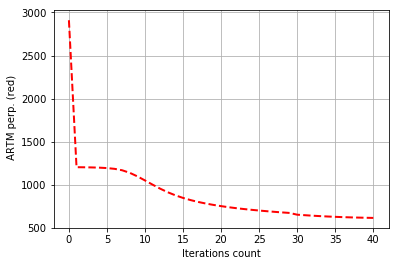

-0.22499999999999998
-0.15
topic_0: 
база_данные
хранение
хранить
механизм
хранилище
храниться
данные
кэш
сущность
хранение_данные
---------
topic_1: 
уязвимость
новость
обнаружить
аккаунт
опубликовать
обнаружение
обнаруженный
жертва
известный
уязвимый
---------
topic_2: 
час
курс
изучать
лекция
студент
минута
занятие
речь
обучение
читать
---------
topic_3: 
оценка
большой_количество
регион
считаться
значительный
фактор
различный
результат
причина
ряд
---------
topic_4: 
результат
общий
показать
иметь
сравнивать
оказаться
два
простой
получить
отличие
---------
topic_5: 
деталь
печать
конструкция
принтер
изделие
позволять
печатать
3d-принтер
цена_рубль
стекло
---------
topic_6: 
комментарий
пост
контроллер
статья
оставить
обратить_внимание
рекомендовать
давать
путь
тема
---------
topic_7: 
база
секунда
минута
лог
статус
пул
нагрузка
запускать
проверять
запускаться
---------
topic_8: 
участник
доклад
конференция
рассказать
презентация
мероприятие
встреча
тема
выступление
рассказывать
---

In [48]:
evaluate('both', 30, 2)

Sparsity Phi: 0.936 ARTM)
Sparsity Theta: 0.670 (ARTM)
Kernel contrast: 0.297 (ARTM)
Kernel purity: 0.526 (ARTM)
Perplexity: 610.739 (ARTM)


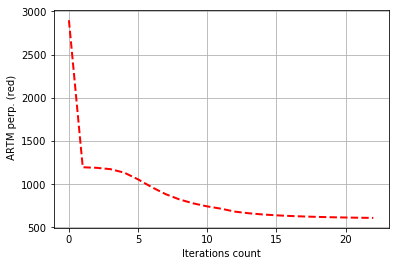

-0.22499999999999998
-0.15
topic_0: 
диск
хранение
хранилище
хранить
кластер
храниться
механизм
данные
размер
хранение_данные
---------
topic_1: 
атака
уязвимость
злоумышленник
информационный_безопасность
хакер
взлом
жертва
уязвимый
угроза
вредоносный_программа
---------
topic_2: 
час
курс
лекция
занятие
речь
обучение
изучать
читать
тема
решить
---------
topic_3: 
являться
регион
организация
различный
значительный
большой_количество
необходимый
результат
причина
нарушение
---------
topic_4: 
компьютер
intel
чип
ассемблер
настоящий
результат
два
операционный_система
смочь
кристалл
---------
topic_5: 
материал
производство
размер
изделие
конструкция
форма
3d-принтер
применение
цена_рубль
позволять
---------
topic_6: 
пост
контроллер
образ
блог
тема
часть
комментарий
роль
путь
заменить
---------
topic_7: 
база
лог
статус
секунда
нагрузка
пул
тестовый
база_данные
триггер
момент
---------
topic_8: 
доклад
конференция
презентация
рассказать
мероприятие
тема
интересный
выступление
встреча
уча

In [52]:
evaluate('both', 12, 4)

Добавим регуляризатор Декоррелирование распределений терминов в темах, который используется для повышения различности лексических ядер предметных тем (вдруг поможет избавиться от похожих слов в топиках на большом количестве итераций).


Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.506 (ARTM)
Kernel contrast: 0.357 (ARTM)
Kernel purity: 0.730 (ARTM)
Perplexity: 613.894 (ARTM)


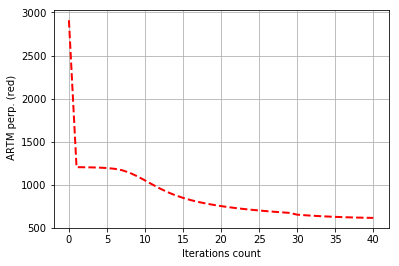

topic_0: 
база_данные
хранение
хранить
механизм
хранилище
храниться
данные
кэш
сущность
хранение_данные
---------
topic_1: 
уязвимость
новость
обнаружить
аккаунт
опубликовать
обнаружение
обнаруженный
жертва
известный
уязвимый
---------
topic_2: 
час
курс
изучать
лекция
студент
минута
занятие
речь
обучение
читать
---------
topic_3: 
оценка
большой_количество
регион
считаться
значительный
фактор
различный
результат
причина
ряд
---------
topic_4: 
результат
общий
показать
иметь
сравнивать
оказаться
два
простой
получить
отличие
---------
topic_5: 
деталь
печать
конструкция
принтер
изделие
позволять
печатать
3d-принтер
цена_рубль
стекло
---------
topic_6: 
комментарий
пост
контроллер
статья
оставить
обратить_внимание
рекомендовать
тема
давать
путь
---------
topic_7: 
база
секунда
минута
лог
статус
пул
нагрузка
запускать
проверять
запускаться
---------
topic_8: 
участник
доклад
конференция
рассказать
презентация
мероприятие
встреча
тема
выступление
рассказывать
---------
topic_9: 
множество


In [55]:
def evaluate():
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(250)])
    model_artm.initialize(dictionary=dictionary, )
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы
    model_artm.num_document_passes = 2
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                                    topic_names=['topic_{}'.format(i) for i in range(1, 250)],
                                                                    ))
    phi_tau = model_artm.regularizers['SparsePhi'].tau
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                                      topic_names=['topic_{}'.format(i) for i in range(1, 250)]))
    theta_tau = model_artm.regularizers['SparseTheta'].tau
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', tau=-0.15, 
                                                                      topic_names=['topic_{}'.format(i) for i in range(1, 250)]))
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

    
    for i in range(10):
        model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
        model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
        model_artm.regularizers['decorrelator_phi_regularizer'].tau = (model_artm.regularizers['decorrelator_phi_regularizer'].tau + (model_artm.regularizers['decorrelator_phi_regularizer'].tau*0.1))
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
            
    print_measures(model_artm)
    for topic_name in model_artm.topic_names[:50]:
        print(topic_name + ': ')
        try:
            for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
                print(x)
            print('---------')

        except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
            continue
evaluate()

# Выводы

* С увеличением количества тем переплексия падает, когерентность растет; из вариантов 150, 200 и 250 лучшим оказался 250.
* С использованием обоих регуляризаторов перплексия меньше, чем с использованием одного или без них
* С повьшением tau обоих регуляризаторов (по десять раз phi на 0.5, theta на 0.1) перплексия падает
* Чем больше итераций по коллекции, тем ниже перплексия; но с какого-то момента (из опробованных вариантов 30 до добавления регуляризаторов) Kernel contrast падает, растет количество однокоренных слов в топиках; когда в 10 топовых словах топика половина - хранение, хранить, хранилище, храниться, хранение\_данные, это не очень информативный топик
* Чем больше итераций по документам, тем ниже перплексия; проблема, что Kernel contrast падает еще сильнее, чем с увеличением итераций на коллекции
* Добавление регуляризатора (с тем же тау, что theta) Декоррелирование распределений терминов в темах почти ничего не меняет

Лучшей по соотношению когерентность выше - перплексия ниже получилась модель, в которой регуляризаторы добавляются после 30 итераций на коллекции. График обучения:

Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.492 (ARTM)
Kernel contrast: 0.358 (ARTM)
Kernel purity: 0.732 (ARTM)
Perplexity: 614.372 (ARTM)


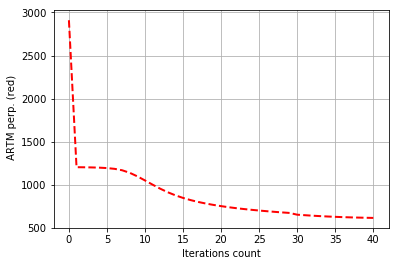

In [63]:
topic_names = evaluate('both', 30, 2)

3 лучших темы

In [64]:
for topic_name in ['topic_29','topic_33','topic_46']:
    print(topic_name)
    for x in topic_names[topic_name]:
        print(x)
    print('---------')

topic_29
цена
товар
покупка
продажа
магазин
заказ
покупатель
скидка
продавец
предложение
---------
topic_33
аппарат
спутник
станция
полёт
земля
двигатель
космос
марс
космический
луна
---------
topic_46
признак
нейронный_сеть
машинный_обучение
вес
нейрон
обучение
распознавание
выборка
точность
классификация
---------
